In [1]:
#Connecting the necessary libraries and functions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras 
from keras.preprocessing import image
from keras.models import Sequential, Model 
from keras.layers import Dropout, MaxPooling2D, Dense, Conv2D, Activation, Flatten 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Declaring constants and labels

class_names = ['NORMAL', 'PNEUMONIA']
nb_classes = len(class_names)
image_size = (220,220)

In [3]:
#Loading a dataset

def load_data():
    
    datasets = ['/kaggle/input/chest-xray-pneumonia/chest_xray/train','/kaggle/input/chest-xray-pneumonia/chest_xray/test']
    images = []
    labels = []

    count =0
    for dataset in datasets:

        for folder in os.listdir(dataset):

            if folder in ['NORMAL']: label = 0
            elif folder in ['PNEUMONIA']: label = 1

            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                img_path = os.path.join(os.path.join(dataset, folder), file)

                image = cv2.imread(img_path)
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                try:
                    image = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)
                except:
                    continue
                images.append(image)
                labels.append(label)
            print()

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [4]:
images, labels = load_data()

100%|██████████| 3875/3875 [01:34<00:00, 40.84it/s]


100%|██████████| 1341/1341 [01:06<00:00, 20.13it/s]


100%|██████████| 390/390 [00:08<00:00, 44.99it/s]


100%|██████████| 234/234 [00:10<00:00, 23.26it/s]


In [5]:
#Split into training, validation and test sets

images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.23)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [6]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training instances: {}".format(n_train))
print("Number of validation instances: {}".format(n_val))
print("Number of test instances: {}".format(n_test))

print("Training set shape: {}".format(train_images.shape))
print("Form of training image values: {}".format(train_labels.shape))
print("Validation sample shape: {}".format(val_images.shape))
print("Form of validation image values: {}".format(val_labels.shape))
print("Test sample shape: {}".format(test_images.shape))
print("Shape of test image values: {}".format(test_labels.shape))

Number of training instances: 4496
Number of validation instances: 672
Number of test instances: 672
Training set shape: (4496, 220, 220, 3)
Form of training image values: (4496,)
Validation sample shape: (672, 220, 220, 3)
Form of validation image values: (672,)
Test sample shape: (672, 220, 220, 3)
Shape of test image values: (672,)


In [7]:
#Data Normalization
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

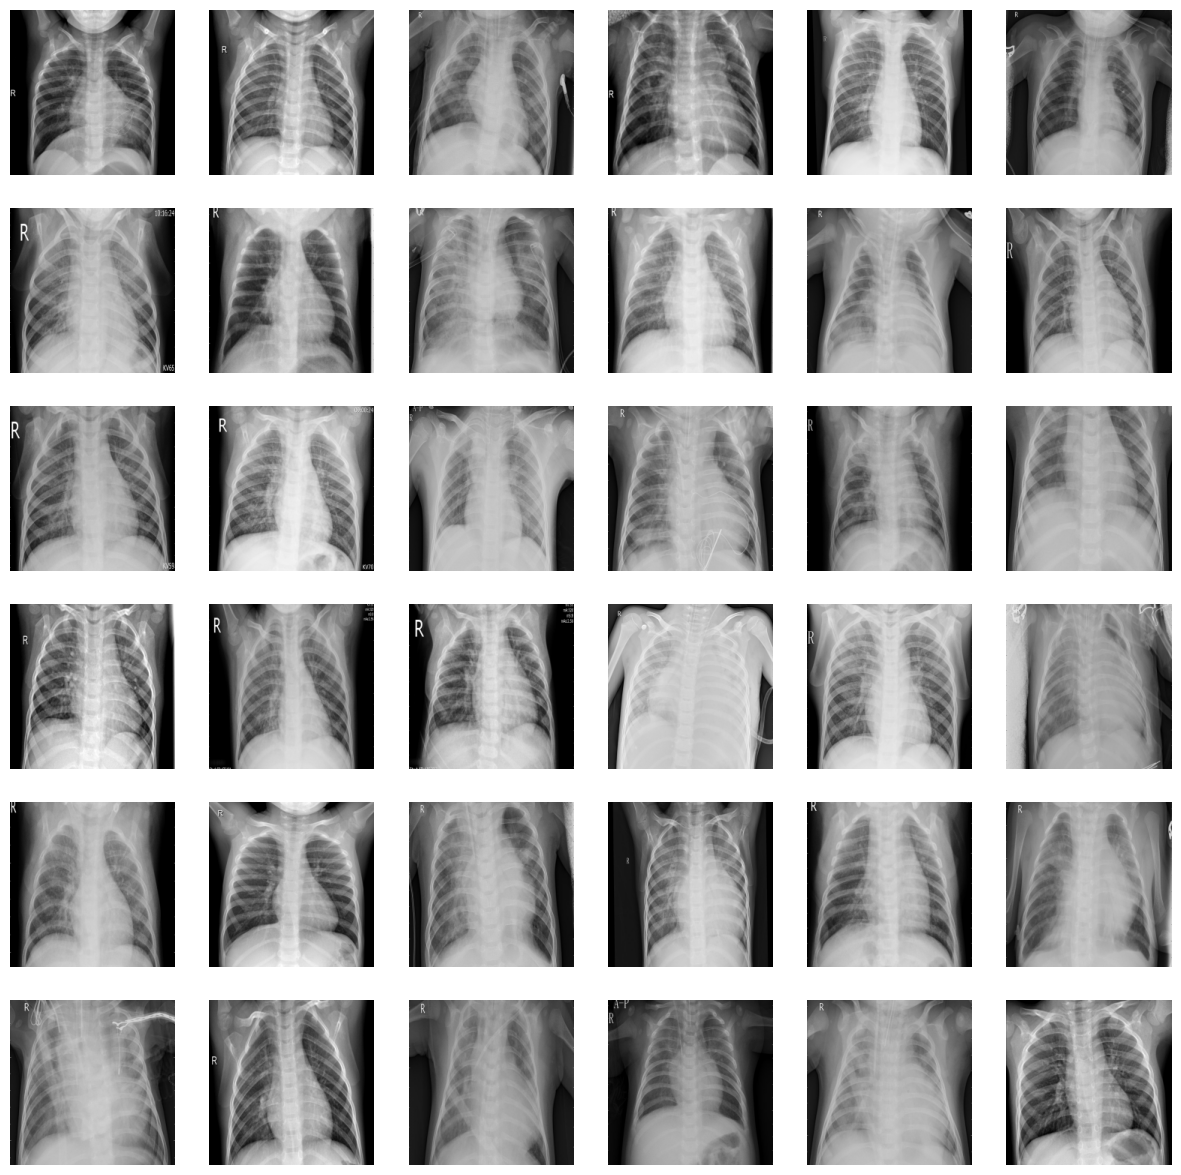

In [8]:
#Rendering some images
plt.figure(figsize=(15,15))
for n,i in enumerate(list(np.random.randint(0,len(train_images),36))):
    plt.subplot(6,6,n+1)
    plt.imshow(train_images[i])
    plt.axis("off")

In [9]:
#Modeling ResNet50V2
resnet50 = ResNet50V2(weights = "imagenet", input_shape = (220,220,3), include_top = False)

94668760/94668760 [==============================] - 1s 0us/step


In [10]:
#Model building
model = Sequential()

model.add(resnet50)

for layer in resnet50.layers:
    layer.trainable = False
    
model.add(Flatten())

model.add(Dense(units = 128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(units = 1, activation = "sigmoid"))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36,410,113
Trainable params: 12,845,313
Non-trainable params: 23,564,800
_________________________________________________________________


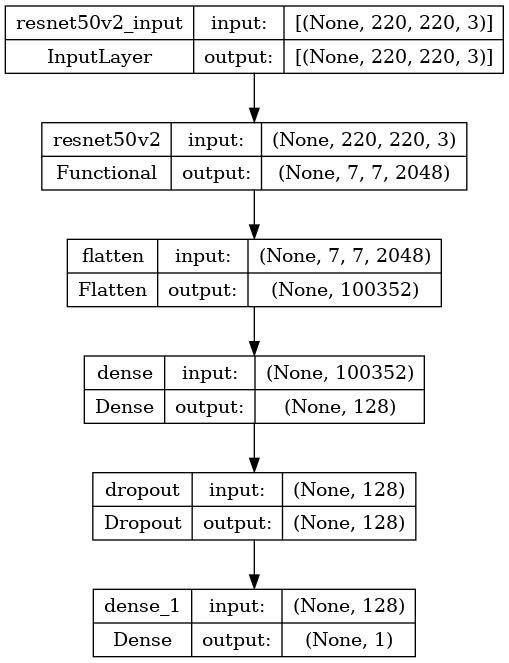

In [11]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
model.summary()
tf.keras.utils.plot_model(
    model, show_layer_names=True, show_shapes=True)

In [12]:
#Training models
history = model.fit(
    x = train_images, 
    y = train_labels, 
    batch_size = 16, 
    epochs = 5, 
    validation_data=(val_images, val_labels)
)

Epoch 1/5
281/281 [==============================] - 21s 41ms/step - loss: 0.6566 - accuracy: 0.8946 - val_loss: 0.1312 - val_accuracy: 0.9539
Epoch 2/5
281/281 [==============================] - 10s 35ms/step - loss: 0.1945 - accuracy: 0.9308 - val_loss: 0.1800 - val_accuracy: 0.9479
Epoch 3/5
281/281 [==============================] - 10s 35ms/step - loss: 0.1878 - accuracy: 0.9397 - val_loss: 0.1114 - val_accuracy: 0.9673
Epoch 4/5
281/281 [==============================] - 10s 35ms/step - loss: 0.1670 - accuracy: 0.9391 - val_loss: 0.1160 - val_accuracy: 0.9539
Epoch 5/5
281/281 [==============================] - 10s 35ms/step - loss: 0.1429 - accuracy: 0.9511 - val_loss: 0.0952 - val_accuracy: 0.9628


In [13]:
#Evaluation models
scores = model.evaluate(test_images, test_labels)
print("Accuracy on test data: %.2f%%" % (scores[1]*100))

21/21 [==============================] - 3s 55ms/step - loss: 0.0987 - accuracy: 0.9643
Accuracy on test data: 96.43%


In [14]:
import tensorflow as tf
from keras.models import load_model

model.save('pneumonia_model.h5')

In [15]:
# Load the saved model
loaded_model = tf.keras.models.load_model('pneumonia_model.h5')

In [19]:
from keras.models import load_model

# Load the trained model
model = load_model('pneumonia_model.h5')

In [20]:
import cv2
import numpy as np

# Load and preprocess the image
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (220, 220), interpolation=cv2.INTER_AREA)
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

In [21]:
# Make predictions
def predict_pneumonia(image_path):
    img = load_and_preprocess_image(image_path)
    prediction = model.predict(img)
    return prediction[0, 0]  # The prediction is a probability

# Define a function to interpret the prediction
def interpret_prediction(prediction):
    if prediction > 0.5:
        return "PNEUMONIA"
    else:
        return "NORMAL"

In [25]:
image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg'  # Replace with the path to your image
prediction = predict_pneumonia(image_path)
result = interpret_prediction(prediction)

print(f"The image is classified as: {result}")

1/1 [==============================] - 0s 22ms/step
The image is classified as: NORMAL


In [26]:
image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg'  # Replace with the path to your image
prediction = predict_pneumonia(image_path)
result = interpret_prediction(prediction)

print(f"The image is classified as: {result}")

1/1 [==============================] - 0s 22ms/step
The image is classified as: PNEUMONIA
